### Imports

In [1]:
import csv
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error,mean_squared_error, make_scorer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
import matplotlib.pyplot as plt
import gensim.downloader as api
#from tensorflow import keras
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlesdemalefette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cells to run

In [ ]:
# Transformers
#--------------------------------------------------------------------------------#
def countElementInStringList(listInString):
    if len(listInString) == 2:
        return 0
    else:
        return listInString.count(',') + 1

class TransformerFeatures(BaseEstimator, TransformerMixin):
    
    """
    Transformer used to prepare the data for the training or the prediction 
    keeping only the usefull features and dropping the text which will be analysed in parallel.
    """
    
    def __init__(self):
        print("init called")

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        #Dropping text, we will treat the text separatly
        X = X.drop(['text'],axis=1)
        
        #Dropping mentions because there are only 0s
        X = X.drop(['mentions'],axis=1)
        
        #Dropping TweetID, assuming that they are completly unrelated to rewteet_count
        X = X.drop(['TweetID'],axis=1)

        #Sorting Indexes so we can work easily with data
        X = X.sort_index().reset_index(drop=True)
        if(y is not None):
            y = y.sort_index().reset_index(drop=True)
            
        #Transform hashtags and urls such as we have the number of each one instead of a list with it inside.
        X['hashtags']=[
            countElementInStringList(X["hashtags"][i]) for i in range(len(X['hashtags']))]
        X['urls']=[
                countElementInStringList(X["urls"][i]) for i in range(len(X['urls']))]
        
        return X, y
    
class TransformerText(BaseEstimator, TransformerMixin):
    
    """
    Transformer used to transform the data to a ndarray that contains the raw text 
    which will be used to train and predict retweet_count
    """
    
    def __init__(self):
        print("init called")

    def fit(self,X,y=None):
        return self
    
    def transform(self,X, vectorizer, train = True):
        if train:
            X_vect = vectorizer.fit_transform(X["text"])
        else:
            X_vect = vectorizer.transform(X["text"])
        
        return X["text"].to_numpy(), X_vect
    
    
    

# Printing results
#--------------------------------------------------------------------------------#
def show_perf_grid(grid,X_train,y_train,X_test, y_test):
    print("The best parameters for this grid search are: ",grid.best_params_,"\n")
    mae_test = mean_absolute_error(grid.best_estimator_.predict(X_test),y_test)
    rmse_test = mean_squared_error(grid.best_estimator_.predict(X_test),y_test)
    mae_train = mean_absolute_error(grid.best_estimator_.predict(X_train),y_train)
    rmse_train = mean_squared_error(grid.best_estimator_.predict(X_train),y_train)
    print("Score for train set")
    print("Mean Absolute Error: ",mae_train)
    print("Mean Squared Error: ",rmse_train)
    print("Score for test set")
    print("Mean Absolute Error: ",mae_test)
    print("Mean Squared Error: ",rmse_test)
    
def show_perf(model,X_train,y_train,X_test, y_test):
    mae_test = mean_absolute_error(model.predict(X_test),y_test)
    rmse_test = mean_squared_error(model.predict(X_test),y_test)
    mae_train = mean_absolute_error(model.predict(X_train),y_train)
    rmse_train = mean_squared_error(model.predict(X_train),y_train)
    print("Score for train set")
    print("Mean Absolute Error: ",mae_train)
    print("Mean Squared Error: ",rmse_train)
    print("Score for test set")
    print("Mean Absolute Error: ",mae_test)
    print("Mean Squared Error: ",rmse_test)
    
def plot_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    plt.figure()
    plt.plot(y_test, y_pred, "b+", label="Prediction of the model")
    plt.plot(y_test,y_test, "gx", label= "Perfect prediction")
    plt.xlabel("y_test")
    plt.ylabel("y_pred") 
    plt.legend()
    plt.show()

# Loss functions
#--------------------------------------------------------------------------------#
def avoidNegativeValueLossFunction(y_pred,y_test):
    """
    Will avoid neagtive value as np.exp(-y_pred) explode when y_pred is too negative
    """
    return mean_absolute_error(y_pred,y_test) + np.exp(-y_pred).max()

In [ ]:
train

In [2]:
test_data = pd.read_csv("test.csv")
transformer = TransformerFeatures()
TweetID = test_data["TweetID"]
test_data, _ = transformer.transform(test_data)

CGCD_model = xgb.XGBRegressor().load_model("CGCD_model.json")
test_data_pred = CGCD_model.predict(test_data)
test_data_pred["TweetID"] = TweetID
test_data_pred.columns = ["retweets_count","TweetID"]
test_data_pred.to_csv("test_data_pred.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [ ]:
# If precedent cell did not work for any reason you can retrain the model with following cell
train_data = pd.read_csv("train.csv")
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(['retweets_count'],axis=1), train_data['retweets_count'], train_size=1, test_size=0)
X_train_features, y_train = transformerFeatures.transform(X_train, y_train)

params = {'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 0.5}
CGCD_model = xgb.XGBRegressor(params=params)

CGCD_model.fit(X_train_features,y_train)

test_data = pd.read_csv("test.csv")
transformer = TransformerFeatures()
TweetID = test_data["TweetID"]
test_data, _ = transformer.transform(test_data)

test_data_pred = CGCD_model.predict(test_data)
test_data_pred["TweetID"] = TweetID
test_data_pred.columns = ["retweets_count","TweetID"]
test_data_pred.to_csv("test_data_pred.csv",index=False)



### Data preprocessing

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(['retweets_count'],axis=1), train_data['retweets_count'], train_size=0.7, test_size=0.3)

#### Utils

In [46]:
# Transformers
#--------------------------------------------------------------------------------#
def countElementInStringList(listInString):
    if len(listInString) == 2:
        return 0
    else:
        return listInString.count(',') + 1

class TransformerFeatures(BaseEstimator, TransformerMixin):
    
    """
    Transformer used to prepare the data for the training or the prediction 
    keeping only the usefull features and dropping the text which will be analysed in parallel.
    """
    
    def __init__(self):
        print("init called")

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        #Dropping text, we will treat the text separatly
        X = X.drop(['text'],axis=1)
        
        #Dropping mentions because there are only 0s
        X = X.drop(['mentions'],axis=1)
        
        #Dropping TweetID, assuming that they are completly unrelated to rewteet_count
        X = X.drop(['TweetID'],axis=1)

        #Sorting Indexes so we can work easily with data
        X = X.sort_index().reset_index(drop=True)
        if(y is not None):
            y = y.sort_index().reset_index(drop=True)
            
        #Transform hashtags and urls such as we have the number of each one instead of a list with it inside.
        X['hashtags']=[
            countElementInStringList(X["hashtags"][i]) for i in range(len(X['hashtags']))]
        X['urls']=[
                countElementInStringList(X["urls"][i]) for i in range(len(X['urls']))]
        
        return X, y
    
class TransformerText(BaseEstimator, TransformerMixin):
    
    """
    Transformer used to transform the data to a ndarray that contains the raw text 
    which will be used to train and predict retweet_count
    """
    
    def __init__(self):
        print("init called")

    def fit(self,X,y=None):
        return self
    
    def transform(self,X, vectorizer, train = True):
        if train:
            X_vect = vectorizer.fit_transform(X["text"])
        else:
            X_vect = vectorizer.transform(X["text"])
        
        return X["text"].to_numpy(), X_vect
    
    
    

# Printing results
#--------------------------------------------------------------------------------#
def show_perf_grid(grid,X_train,y_train,X_test, y_test):
    print("The best parameters for this grid search are: ",grid.best_params_,"\n")
    mae_test = mean_absolute_error(grid.best_estimator_.predict(X_test),y_test)
    rmse_test = mean_squared_error(grid.best_estimator_.predict(X_test),y_test)
    mae_train = mean_absolute_error(grid.best_estimator_.predict(X_train),y_train)
    rmse_train = mean_squared_error(grid.best_estimator_.predict(X_train),y_train)
    print("Score for train set")
    print("Mean Absolute Error: ",mae_train)
    print("Mean Squared Error: ",rmse_train)
    print("Score for test set")
    print("Mean Absolute Error: ",mae_test)
    print("Mean Squared Error: ",rmse_test)
    
def show_perf(model,X_train,y_train,X_test, y_test):
    mae_test = mean_absolute_error(model.predict(X_test),y_test)
    rmse_test = mean_squared_error(model.predict(X_test),y_test)
    mae_train = mean_absolute_error(model.predict(X_train),y_train)
    rmse_train = mean_squared_error(model.predict(X_train),y_train)
    print("Score for train set")
    print("Mean Absolute Error: ",mae_train)
    print("Mean Squared Error: ",rmse_train)
    print("Score for test set")
    print("Mean Absolute Error: ",mae_test)
    print("Mean Squared Error: ",rmse_test)
    
def plot_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    plt.figure()
    plt.plot(y_test, y_pred, "b+", label="Prediction of the model")
    plt.plot(y_test,y_test, "gx", label= "Perfect prediction")
    plt.xlabel("y_test")
    plt.ylabel("y_pred") 
    plt.legend()
    plt.show()

# Loss functions
#--------------------------------------------------------------------------------#
def avoidNegativeValueLossFunction(y_pred,y_test):
    """
    Will avoid neagtive value as np.exp(-y_pred) explode when y_pred is too negative
    """
    return mean_absolute_error(y_pred,y_test) + np.exp(-y_pred).max()

In [21]:
####
#
# We transform the data with our transformers
#
####

transformerFeatures = TransformerFeatures()
transformerText = TransformerText()

X_train_features, y_train = transformerFeatures.transform(X_train, y_train)
X_test_features, y_test = transformerFeatures.transform(X_test, y_test)

vectorizer = TfidfVectorizer(
    max_features=100, stop_words=stopwords.words('french'))

X_train_text, X_train_text_vect = transformerText.transform(X_train, vectorizer, train=True)
X_test_text, X_test_text_vect = transformerText.transform(X_test, vectorizer, train=False)

init called
init called


### Models evaluated on the text only

#### XGBoost

In [24]:
# We are trying with XGBoost
xgbr = xgb.XGBRegressor()
param_grid_xgbr = {"n_estimators": [50,100,150], "learning_rate":[0.01,0.05,0.1], "max_depth":[1,2,4], "subsample":[0.3,0.5,0.7,]}
best_xgbr_text = GridSearchCV(xgbr,param_grid_xgbr,scoring= "neg_mean_absolute_error",n_jobs=-1)

In [ ]:
best_xgbr_text.fit(X_train_text_vect,y_train)

In [ ]:
show_perf_grid(best_xgbr_text,X_train_text_vect, y_train, X_test_text_vect, y_test)

In [ ]:
plot_pred(best_xgbr_text.best_estimator_, X_test_text_vect, y_test)

### Models on the other features

#### XGBoost

In [26]:
# It appears that the best parameters amongst the ones that we tryed are the ones by default so we kept them for the evaluation
xgbr_features = xgb.XGBRegressor(n_estimators =120, max_depth = 7, learning_rate = 0.2, subsample = 0.80, random_state=0)
param_grid_xgbr = {"n_estimators": [50,100], "learning_rate": [0.1,0.3,0.6], "subsample":[0.1,0.5,1]}
best_xgbr_features = GridSearchCV(xgbr_features,param_grid_xgbr, scoring=make_scorer(mean_absolute_error))

In [27]:
best_xgbr_features.fit(X_train_features,y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.2, max_bin...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=7, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=120,
      

In [28]:
# We have now a quite nice mean_squared_error, significantly better for the train split than for the test split, as usual.

show_perf_grid(best_xgbr_features,X_train_features,y_train,X_test_features,y_test)

The best parameters for this grid search are:  {'learning_rate': 0.6, 'n_estimators': 100, 'subsample': 0.1} 

Score for train set
Mean Absolute Error:  11.132762179880398
Mean Squared Error:  33153.089183600714
Score for test set
Mean Absolute Error:  16.678155968032044
Mean Squared Error:  118004.0514658972


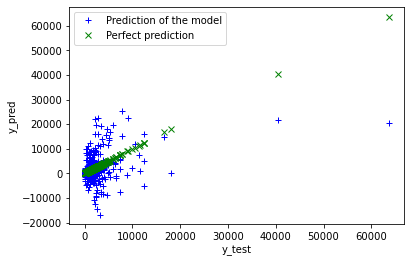

In [29]:
# Let's see our data, it predict some negative value, down to around -10000, 
# we can maybe change that by modifying the loss function 

plot_pred(best_xgbr_features.best_estimator_, X_test_features, y_test)

In [47]:
# Test with our custom loss function
best_xgbr_features_without_neg = GridSearchCV(xgbr_features,
                                              param_grid_xgbr, 
                                              scoring=make_scorer(avoidNegativeValueLossFunction, greater_is_better= False))

In [69]:
best_xgbr_features_without_neg.fit(X_train_features,y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.2, max_bin...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=7, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=120,
      

In [70]:
show_perf_grid(best_xgbr_features_without_neg,X_train_features,y_train,X_test_features,y_test)

The best parameters for this grid search are:  {'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 0.5} 

Score for train set
Mean Absolute Error:  4.766276674374589
Mean Squared Error:  1933.2306142675284
Score for test set
Mean Absolute Error:  6.637745246775139
Mean Squared Error:  26897.112802411455


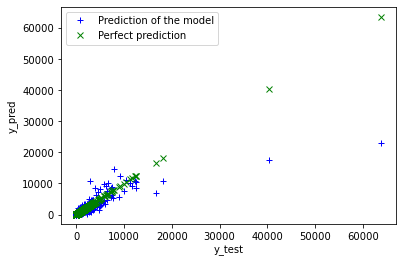

In [71]:
# As planned, there are slightly less negative value which is more realistic.

plot_pred(best_xgbr_features_without_neg.best_estimator_, X_test_features, y_test)

In [72]:
# We save this model as "CGCD_model.json"
best_xgbr_features_without_neg.best_estimator_.save_model("CGCD_model.json")

### Neural Network for text regression

In [298]:
# We create a Neural Network with 2 hidden layers

inputs = keras.layers.Input(shape = (100,))
dense1 = keras.layers.Dense(50, activation="sigmoid")(inputs)
dense2 = keras.layers.Dense(25, activation="sigmoid")(dense1)
outputs = keras.layers.Dense(1)(dense2)
textModel = keras.Model(inputs=inputs,outputs=outputs)

In [305]:
textModel.compile(optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
                loss = keras.losses.MeanAbsoluteError(),
                metrics = [keras.metrics.RootMeanSquaredError(),keras.metrics.MeanSquaredError(),keras.metrics.MeanAbsoluteError()])

In [306]:
# Fitting our model on the text, the result is disapointing, the NN do not find anything

history = textModel.fit(X_train_text_vect.todense(),y_train,epochs = 10, verbose=2)

Epoch 1/10
7744/7744 - 4s - loss: 15.5097 - root_mean_squared_error: 215.3741 - mean_squared_error: 46386.0000 - mean_absolute_error: 15.5097 - 4s/epoch - 543us/step
Epoch 2/10
7744/7744 - 4s - loss: 15.5097 - root_mean_squared_error: 215.3736 - mean_squared_error: 46385.7695 - mean_absolute_error: 15.5097 - 4s/epoch - 516us/step
Epoch 3/10
7744/7744 - 4s - loss: 15.5097 - root_mean_squared_error: 215.3744 - mean_squared_error: 46386.1172 - mean_absolute_error: 15.5097 - 4s/epoch - 516us/step
Epoch 4/10
7744/7744 - 4s - loss: 15.5096 - root_mean_squared_error: 215.3732 - mean_squared_error: 46385.6250 - mean_absolute_error: 15.5096 - 4s/epoch - 514us/step
Epoch 5/10
7744/7744 - 4s - loss: 15.5096 - root_mean_squared_error: 215.3740 - mean_squared_error: 46385.9609 - mean_absolute_error: 15.5096 - 4s/epoch - 520us/step
Epoch 6/10
7744/7744 - 4s - loss: 15.5096 - root_mean_squared_error: 215.3760 - mean_squared_error: 46386.8320 - mean_absolute_error: 15.5096 - 4s/epoch - 513us/step
Epoc

In [304]:
mean_absolute_error(textModel.predict(X_test_text_vect.todense()),y_test)

3319/3319 [==============================] - 2s 452us/step


16.54944662517208

3319/3319 [==============================] - 2s 453us/step


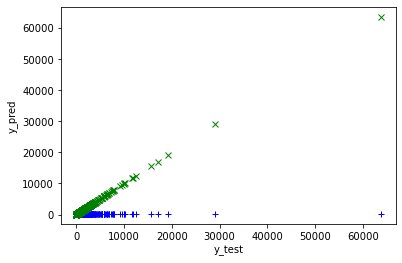

In [301]:
# Plotting the prediction, the NN gives us the mean of the values to minimize mean_abolute_error

plot_pred(textModel,X_test_text_vect.todense(),y_test)

In [308]:
# We are now trying several models with autokeras to see if we still can find a good NN to predict the retweet count

from autokeras import TextRegressor

In [327]:
X_train_text = X_train["text"].to_numpy()

In [310]:
text_reg = TextRegressor(output_dim = 1, loss="mean_absolute_error", seed=42)

In [329]:
# After 1h30 of research, 8 Network tried, the mean_absolut_error is still locked to ~15,5
text_reg.fit(X_train_text,y_train,epochs=10,verbose=2)

Trial 8 Complete [00h 13m 31s]
val_loss: 15.49724006652832

Best val_loss So Far: 15.497112274169922
Total elapsed time: 01h 28m 50s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
vanilla           |vanilla           |text_block_1/block_type
5000              |5000              |text_block_1/max_tokens
64                |64                |text_block_1/text_to_int_sequence_1/output_sequence_length
none              |none              |text_block_1/embedding_1/pretraining
128               |128               |text_block_1/embedding_1/embedding_dim
0.25              |0.25              |text_block_1/embedding_1/dropout
3                 |3                 |text_block_1/conv_block_1/kernel_size
False             |False             |text_block_1/conv_block_1/separable
True              |True              |text_block_1/conv_block_1/max_pooling
3                 |3                 |text_block_1/conv_block_1/num_blocks
2                 |2                 |text

KeyboardInterrupt: 

### Using the model on the Evaluation dataset

In [ ]:
# Portion of code we used to predict retweet counts on the evaluation dataset

transformerFeatures = TransformerFeatures()
evaluation_data = pd.read_csv("evaluation.csv")
TweetID = evaluation_data["TweetID"]
evaluation_data,_ = transformerFeatures.transform(evaluation_data)
y_pred = pd.DataFrame(best_xgbr_features_without_neg.best_estimator_.predict(evaluation_data))
y_pred["TweetID"] = TweetID
y_pred.columns = ["retweets_count","TweetID"]
y_pred.to_csv("CGCD_eigth_attempt.csv",index=False)